# Train your dog using TF-Agents





In [4]:
!pip install tf-agents

     |████████████████████████████████| 1.1MB 13.4MB/s 


### Imports

In [5]:
from enum import Enum
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.trajectories import time_step as timeStep

from tf_agents.policies import random_tf_policy

from tf_agents.metrics import tf_py_metric
from tf_agents.metrics import tf_metrics
from tf_agents.metrics import py_metric
from tf_agents.drivers import py_driver
from tf_agents.drivers import dynamic_episode_driver

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.networks import q_network
from tf_agents.replay_buffers import tf_uniform_replay_buffer

from tf_agents.policies import random_tf_policy
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

from tf_agents.policies import policy_saver

In [6]:
def column(matrix, i):
    return [row[i] for row in matrix]

### Game Environment

In [7]:
class ActionResult(Enum):
    VALID_MOVE = 1
    ILLEGAL_MOVE = 2
    FOUND_BONE = 3
    FOUND_ROBOT = 4
    GAME_COMPLETE = 5

In [8]:
class DogAdventure():
    def __init__(self):
        self._state = np.zeros((36,),dtype=np.int32)
        self._robot_locations = [6,10,14,25,33]
        self._bone_locations = [5,7,9,16,19,26,30]
        self._state[self._robot_locations] = 2
        self._state[self._bone_locations] = 3
        self._state[0] = 1
        self._game_ended = False

    def reset(self):
        self._state = np.zeros((36,),dtype=np.int32)
        self._state[self._robot_locations] = 2
        self._state[self._bone_locations] = 3
        self._state[0] = 1
        self._game_ended = False

    def __is_spot_last(self, position):
        return position == 35

    def move_dog(self, current_position, next_position):

        if self.__is_spot_last(next_position):
            self._state[current_position] = 0
            self._state[next_position] = 1

            self._game_ended = True
            return ActionResult.GAME_COMPLETE

        if next_position < 0 or next_position > (len(self._state) - 1):
            self._game_ended = True
            return ActionResult.ILLEGAL_MOVE

        if self._state[next_position] == 2:
            self._game_ended = True
            return ActionResult.FOUND_ROBOT

        if self._state[next_position] == 3:
            self._state[current_position] = 0
            self._state[next_position] = 1
            return ActionResult.FOUND_BONE

        self._state[current_position] = 0
        self._state[next_position] = 1

        return ActionResult.VALID_MOVE

    def game_ended(self):
        return self._game_ended
  
    def game_state(self):
        return self._state

In [9]:
class DogAdventureEnvironment(py_environment.PyEnvironment):

    def __init__(self, game):
        self._action_spec = array_spec.BoundedArraySpec(
            shape=(), dtype=np.int32, minimum=0, maximum=3, name='action')
        self._observation_spec = array_spec.BoundedArraySpec(
            shape=(36,), dtype=np.int32, minimum=0, maximum=3, name='observation')

        # 0=>Left, 1=>Right, 2=>Down, 3=>Up
        self._action_values = {0:-1,1:1,2:-6,3:6}
        self._game = game

    def action_spec(self):
        return self._action_spec

    def observation_spec(self):
        return self._observation_spec

    def _reset(self):
        self._game.reset()
        return timeStep.restart(self._game.game_state())
  
    def _step(self, action):    

        if self._game.game_ended():
            return self.reset()

        action = action.item()

        next_agent_position_direction = self._action_values.get(action)
        current_agent_position = np.where(self._game.game_state() == 1)[0].item()
        new_agent_position = current_agent_position + next_agent_position_direction

        response = self._game.move_dog(current_agent_position,new_agent_position)

        if response == ActionResult.GAME_COMPLETE:
            return timeStep.termination(self._game.game_state(), 10)

        elif response == ActionResult.ILLEGAL_MOVE:
            return timeStep.termination(self._game.game_state(), -0.3)

        elif response == ActionResult.FOUND_ROBOT:
            return timeStep.termination(self._game.game_state(), -0.3)

        elif response == ActionResult.FOUND_BONE:
            return timeStep.transition(self._game.game_state(), reward=1, discount=1.0)

        return timeStep.transition(self._game.game_state(), reward=-0.3, discount=1.0)


In [10]:
dogEnvironemt = DogAdventureEnvironment(DogAdventure())
utils.validate_py_environment(dogEnvironemt, episodes=5)

In [11]:
train_env = tf_py_environment.TFPyEnvironment(dogEnvironemt)
eval_env = tf_py_environment.TFPyEnvironment(dogEnvironemt)

### DQN Setup

In [12]:
fc_layer_params = [32,64,128]

q_net = q_network.QNetwork(
            train_env.observation_spec(),
            train_env.action_spec(),
            fc_layer_params = fc_layer_params
        )

train_step = tf.Variable(0)
update_period = 4
optimizer = tf.keras.optimizers.Adam(lr=2.5e-4, epsilon=0.00001)

epsilon_fn = tf.keras.optimizers.schedules.PolynomialDecay(
                initial_learning_rate=1.0, 
                decay_steps=250000 // update_period,
                end_learning_rate=0.01)

agent = dqn_agent.DdqnAgent(
        train_env.time_step_spec(),
        train_env.action_spec(),
        q_network=q_net,
        optimizer=optimizer,
        target_update_period=2000,
        td_errors_loss_fn=tf.keras.losses.Huber(reduction="none"),
        gamma=0.99,
        train_step_counter=train_step,
        epsilon_greedy=lambda: epsilon_fn(train_step))

agent.initialize()

### Replay Buffer Setup

In [13]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=1000000)

replay_buffer_observer = replay_buffer.add_batch

### Metrics Setup

In [14]:
train_metrics = [tf_metrics.AverageReturnMetric(), tf_metrics.AverageEpisodeLengthMetric()]

### Driver Setup

In [15]:
collect_driver = dynamic_step_driver.DynamicStepDriver(
    train_env,
    agent.collect_policy,
    observers=[replay_buffer_observer] + train_metrics,
    num_steps=update_period)

### Collect trajectories using Random Policy

In [16]:
class ShowProgress:
    def __init__(self, total):
        self.counter = 0
        self.total = total
    def __call__(self, trajectory):
        if not trajectory.is_boundary():
            self.counter += 1
        if self.counter % 100 == 0:
            print("\r{}/{}".format(self.counter, self.total), end="")

In [17]:
initial_collect_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(), train_env.action_spec())

init_driver = dynamic_step_driver.DynamicStepDriver(
    train_env,
    initial_collect_policy,
    observers=[replay_buffer.add_batch, ShowProgress(20000)],
    num_steps=20000)

final_time_step, final_policy_state = init_driver.run()

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


20000/20000

### Verify collected trajectories

In [18]:
trajectories, buffer_info = replay_buffer.get_next(sample_batch_size=2, num_steps=10)

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


In [19]:
trajectories._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

In [20]:
time_steps, action_steps, next_time_steps = trajectory.to_transition(trajectories)
time_steps.observation.shape

TensorShape([2, 9, 36])

### Create Dataset from Replay Buffer

In [21]:
dataset = replay_buffer.as_dataset(sample_batch_size=100, num_steps=2, num_parallel_calls=3).prefetch(3)

### Run it under common function to make it faster

In [22]:
collect_driver.run = common.function(collect_driver.run)
agent.train = common.function(agent.train)

### Train

In [23]:
all_train_loss = []
all_metrics = []

In [24]:
def train_agent(n_iterations):
    time_step = None
    policy_state = agent.collect_policy.get_initial_state(train_env.batch_size)
    iterator = iter(dataset)
    
    for iteration in range(n_iterations):
        current_metrics = []
        
        time_step, policy_state = collect_driver.run(time_step, policy_state)
        trajectories, buffer_info = next(iterator)
        
        train_loss = agent.train(trajectories)
        all_train_loss.append(train_loss.loss.numpy())

        for i in range(len(train_metrics)):
            current_metrics.append(train_metrics[i].result().numpy())
            
        all_metrics.append(current_metrics)
        
        if iteration % 500 == 0:
            print("\nIteration: {}, loss:{:.2f}".format(iteration, train_loss.loss.numpy()))
            
            for i in range(len(train_metrics)):
                print('{}: {}'.format(train_metrics[i].name, train_metrics[i].result().numpy()))

In [25]:
train_agent(150000)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))



Iteration: 0, loss:0.08
AverageReturn: -0.30000001192092896
AverageEpisodeLength: 1.0

Iteration: 500, loss:0.02
AverageReturn: -0.3699999749660492
AverageEpisodeLength: 2.0999999046325684

Iteration: 1000, loss:0.03
AverageReturn: -0.7299999594688416
AverageEpisodeLength: 3.299999952316284

Iteration: 1500, loss:0.01
AverageReturn: -0.44999998807907104
AverageEpisodeLength: 1.5

Iteration: 2000, loss:0.02
AverageReturn: -0.4399999976158142
AverageEpisodeLength: 1.899999976158142

Iteration: 2500, loss:0.01
AverageReturn: -0.4399999976158142
AverageEpisodeLength: 1.899999976158142

Iteration: 3000, loss:0.01
AverageReturn: -0.6000000238418579
AverageEpisodeLength: 2.0

Iteration: 3500, loss:0.01
AverageReturn: -0.23000001907348633
AverageEpisodeLength: 1.2000000476837158

Iteration: 4000, loss:0.02
AverageReturn: -0.4000000059604645
AverageEpisodeLength: 2.200000047683716

Iteration: 4500, loss:0.02
AverageReturn: -0.2800000309944153
AverageEpisodeLength: 1.7999999523162842

Iteration

In [26]:
avg_return_trained = column(all_metrics,0)
avg_ep_trained = column(all_metrics,1)

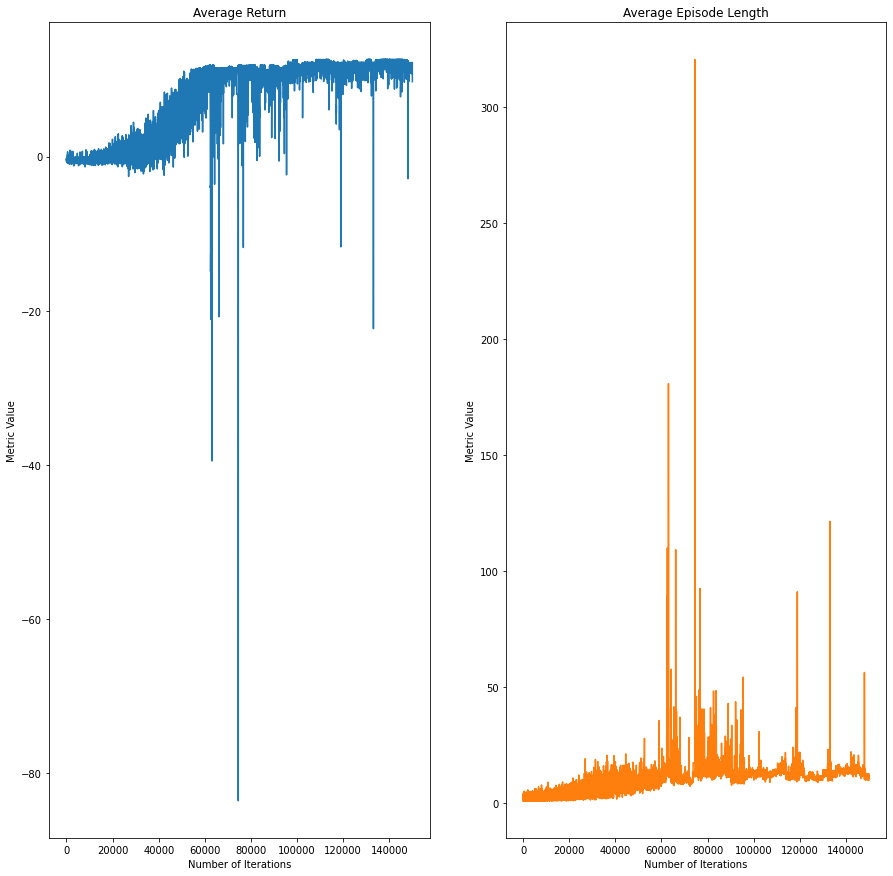

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(15,15))

axs[0].plot(range(len(avg_return_trained)), avg_return_trained)
axs[0].set_title('Average Return')

axs[1].plot(range(len(avg_ep_trained)), avg_ep_trained, 'tab:orange')
axs[1].set_title('Average Episode Length')

for ax in axs.flat:
    ax.set(xlabel='Number of Iterations', ylabel='Metric Value')

### Evaluate

In [28]:
def compute_avg_return(environment, policy, num_episodes=10):

    total_return = 0.0
    
    for _ in range(num_episodes):
        time_step = environment.reset()
        episode_return = 0.0
        
        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        
        total_return += episode_return

    avg_return = total_return / num_episodes
    
    return avg_return.numpy()[0]

In [29]:
# Reset the train step
agent.train_step_counter.assign(0)

#reset eval environment
eval_env.reset()

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, 5)

In [30]:
avg_return

12.2

### Visualize Episode

In [31]:
def observation_viz(observation):
    numpy_obs = observation.numpy()[0]
    string_obs = np.array(np.reshape(numpy_obs, (-1, 6)), dtype=np.unicode_)
    if string_obs[5][5] != "1":
      string_obs[5][5] = "❌"
    string_obs = np.where(string_obs=="1","🐕", string_obs) 
    string_obs = np.where(string_obs=="2","🤖", string_obs)
    string_obs = np.where(string_obs=="3","🦴", string_obs)
    string_obs = np.where(string_obs=="0","⬚", string_obs)
    observe_2d = pd.DataFrame(string_obs)
    observe_2d.columns = [''] * len(observe_2d.columns)
    observe_2d = observe_2d.to_string(index=False)
    print("\n{}\n".format(observe_2d))

In [32]:
def compute_viz(environment, policy, num_episodes=20):

    total_return = 0.0
    
    for _ in range(num_episodes):
        time_step = environment.reset()
        episode_return = 0.0
        step = 0
        print("Step: 0")
        observation_viz(time_step.observation)
        while not time_step.is_last():
            step += 1
            print("---\nStep: {}".format(step))
            action_step = policy.action(time_step)
            print("Action taken: {}".format(action_step.action))
            time_step = environment.step(action_step.action)
            observation_viz(time_step.observation)
            episode_return += time_step.reward
            print("Reward: {} \n".format(episode_return))
        
        total_return += episode_return

    avg_return = total_return / num_episodes
    
    return avg_return.numpy()[0]

In [33]:
# Reset the train step
agent.train_step_counter.assign(0)

#reset eval environment
eval_env.reset()

# Evaluate the agent's policy once before training.
avg_return = compute_viz(eval_env, agent.policy, 1)

Step: 0

                 
 🐕  ⬚  ⬚  ⬚  ⬚  🦴
 🤖  🦴  ⬚  🦴  🤖  ⬚
 ⬚  ⬚  🤖  ⬚  🦴  ⬚
 ⬚  🦴  ⬚  ⬚  ⬚  ⬚
 ⬚  🤖  🦴  ⬚  ⬚  ⬚
 🦴  ⬚  ⬚  🤖  ⬚  ❌

---
Step: 1
Action taken: [1]

                 
 ⬚  🐕  ⬚  ⬚  ⬚  🦴
 🤖  🦴  ⬚  🦴  🤖  ⬚
 ⬚  ⬚  🤖  ⬚  🦴  ⬚
 ⬚  🦴  ⬚  ⬚  ⬚  ⬚
 ⬚  🤖  🦴  ⬚  ⬚  ⬚
 🦴  ⬚  ⬚  🤖  ⬚  ❌

Reward: [-0.3] 

---
Step: 2
Action taken: [3]

                 
 ⬚  ⬚  ⬚  ⬚  ⬚  🦴
 🤖  🐕  ⬚  🦴  🤖  ⬚
 ⬚  ⬚  🤖  ⬚  🦴  ⬚
 ⬚  🦴  ⬚  ⬚  ⬚  ⬚
 ⬚  🤖  🦴  ⬚  ⬚  ⬚
 🦴  ⬚  ⬚  🤖  ⬚  ❌

Reward: [0.7] 

---
Step: 3
Action taken: [3]

                 
 ⬚  ⬚  ⬚  ⬚  ⬚  🦴
 🤖  ⬚  ⬚  🦴  🤖  ⬚
 ⬚  🐕  🤖  ⬚  🦴  ⬚
 ⬚  🦴  ⬚  ⬚  ⬚  ⬚
 ⬚  🤖  🦴  ⬚  ⬚  ⬚
 🦴  ⬚  ⬚  🤖  ⬚  ❌

Reward: [0.39999998] 

---
Step: 4
Action taken: [3]

                 
 ⬚  ⬚  ⬚  ⬚  ⬚  🦴
 🤖  ⬚  ⬚  🦴  🤖  ⬚
 ⬚  ⬚  🤖  ⬚  🦴  ⬚
 ⬚  🐕  ⬚  ⬚  ⬚  ⬚
 ⬚  🤖  🦴  ⬚  ⬚  ⬚
 🦴  ⬚  ⬚  🤖  ⬚  ❌

Reward: [1.4] 

---
Step: 5
Action taken: [1]

                 
 ⬚  ⬚  ⬚  ⬚  ⬚  🦴
 🤖  ⬚  ⬚  🦴  🤖  ⬚
 ⬚  ⬚  🤖  ⬚  🦴  ⬚
 ⬚  ⬚  🐕  ⬚  ⬚  ⬚
 ⬚  🤖  🦴  ⬚  ⬚  ⬚
 🦴  ⬚  ⬚  🤖  ⬚  ❌

Re

### Saving/Loading the Agent

In [34]:
from datetime import datetime

In [35]:
folder_name = datetime.now().timestamp()
folder_name = "/content/saved_agents/"+str(folder_name)

#### Saving the agent

In [36]:
tf.saved_model.save(agent, folder_name)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: /content/saved_agents/1608125988.317696/assets


INFO:tensorflow:Assets written to: /content/saved_agents/1608125988.317696/assets


In [37]:
!zip -r saved_agent.zip /content/saved_agents/1590937968.715281/

	zip warning: name not matched: /content/saved_agents/1590937968.715281/

zip error: Nothing to do! (try: zip -r saved_agent.zip . -i /content/saved_agents/1590937968.715281/)


#### Loading the agent